In [1]:
# Install required libraries
if False:
    ! conda update -n base conda -y -q
    ! conda install tensorflow -y -q
    ! conda install scipy -y -q
    ! conda install matplotlib -y -q
    ! conda install pillow -y -q
    ! conda install PIL -y -q
    ! conda install scikit-image -y -q

In [2]:
#import libraries
import tensorflow as tf
import numpy as np

import os
import sys

import scipy
from scipy import ndimage, misc
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

In [3]:
# Class for a dataset
class DataSet(object):
    """Dataset class object."""

    def __init__(self, images, labels):
        """Initialize the class."""
        self._images = images
        self._num_examples = images.shape[0]
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._epochs_changed = False

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    @property
    def epochs_changed(self):
        if self._epochs_changed:
            self._epochs_changed = False
            return True
        return False

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            self._epochs_changed = True
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end]

## Prameters

In [4]:
global batch_size, epochs
height, width = 256/2, 256/2
batch_size = 32
epochs = 50
n_classes = 20
n_input = height * width

print 'Input Size:',n_input
print 'Number of Classes:', n_classes
print 'Batch Size:', batch_size
print 'Epochs:', epochs

Input Size: 16384
Number of Classes: 20
Batch Size: 32
Epochs: 50


In [5]:
# function to resize images
def resize_image(img):
    global height, width
    r_img = resize(img,(height,width,3),mode='constant')
    return r_img

In [6]:
def replace_cmd_line(output):
    """Replace the last command line output with the given output."""
    sys.stdout.write(output)
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()

In [7]:
# Load Data from folders
def LoadData(path):
    global new_classes
    new_classes = os.listdir(path)[:n_classes]
    
    prompt="Loading Data: "
    
    n = 0
    images = []
    labels = []
    for label in new_classes:
        for img_file in os.listdir(path + label)[-5:]:
            img = ndimage.imread(path+label+"/"+img_file,mode='RGB')
            images.append(resize_image(img))
            replace_cmd_line(prompt+label+' '+img_file)
            labels.append(n)
        n+=1

    images = np.array(images)
    labels = np.array(labels)
    labels = np.identity(n_classes)[labels]
    
    print prompt+"Done"+" "*30
    
    return DataSet(images, labels)

In [8]:
# testset = LoadData("../data/faces_images/")
testset = LoadData("../Images/")

Loading Data: Done                              


In [9]:
print '\t\tImages\t\t\tLabels'
print 'Testing:\t', testset.images.shape,'\t', testset.labels.shape

		Images			Labels
Testing:	(50, 128, 128, 3) 	(50, 20)


In [10]:
import pickle
file = open("classes"+str(n_classes)+".pkl")
classes = pickle.load(file)
classes

['Abbie_Cornish',
 'A.J._Buckley',
 'Aamir_Khan',
 'Adam_Driver',
 'Adam_Baldwin',
 'Adam_Buxton',
 'Abigail_Spencer',
 'Abraham_Benrubi',
 'Adam_Brody',
 'Adam_Copeland',
 'Abigail_Klein',
 'Abigail_Breslin',
 'Adam_Beach',
 'A_P_J_Abdul_Kalam',
 'Aaron_Yoo',
 'Abel_Ferrara',
 'A.R._Rahman',
 'Aaron_Staton',
 'Adam_G._Sevani',
 'Aaron_Tveit']

In [11]:
checkpoint_file=tf.train.latest_checkpoint(".")

In [12]:
graph = tf.Graph()

INFO:tensorflow:Restoring parameters from ./model20.ckpt
0.98


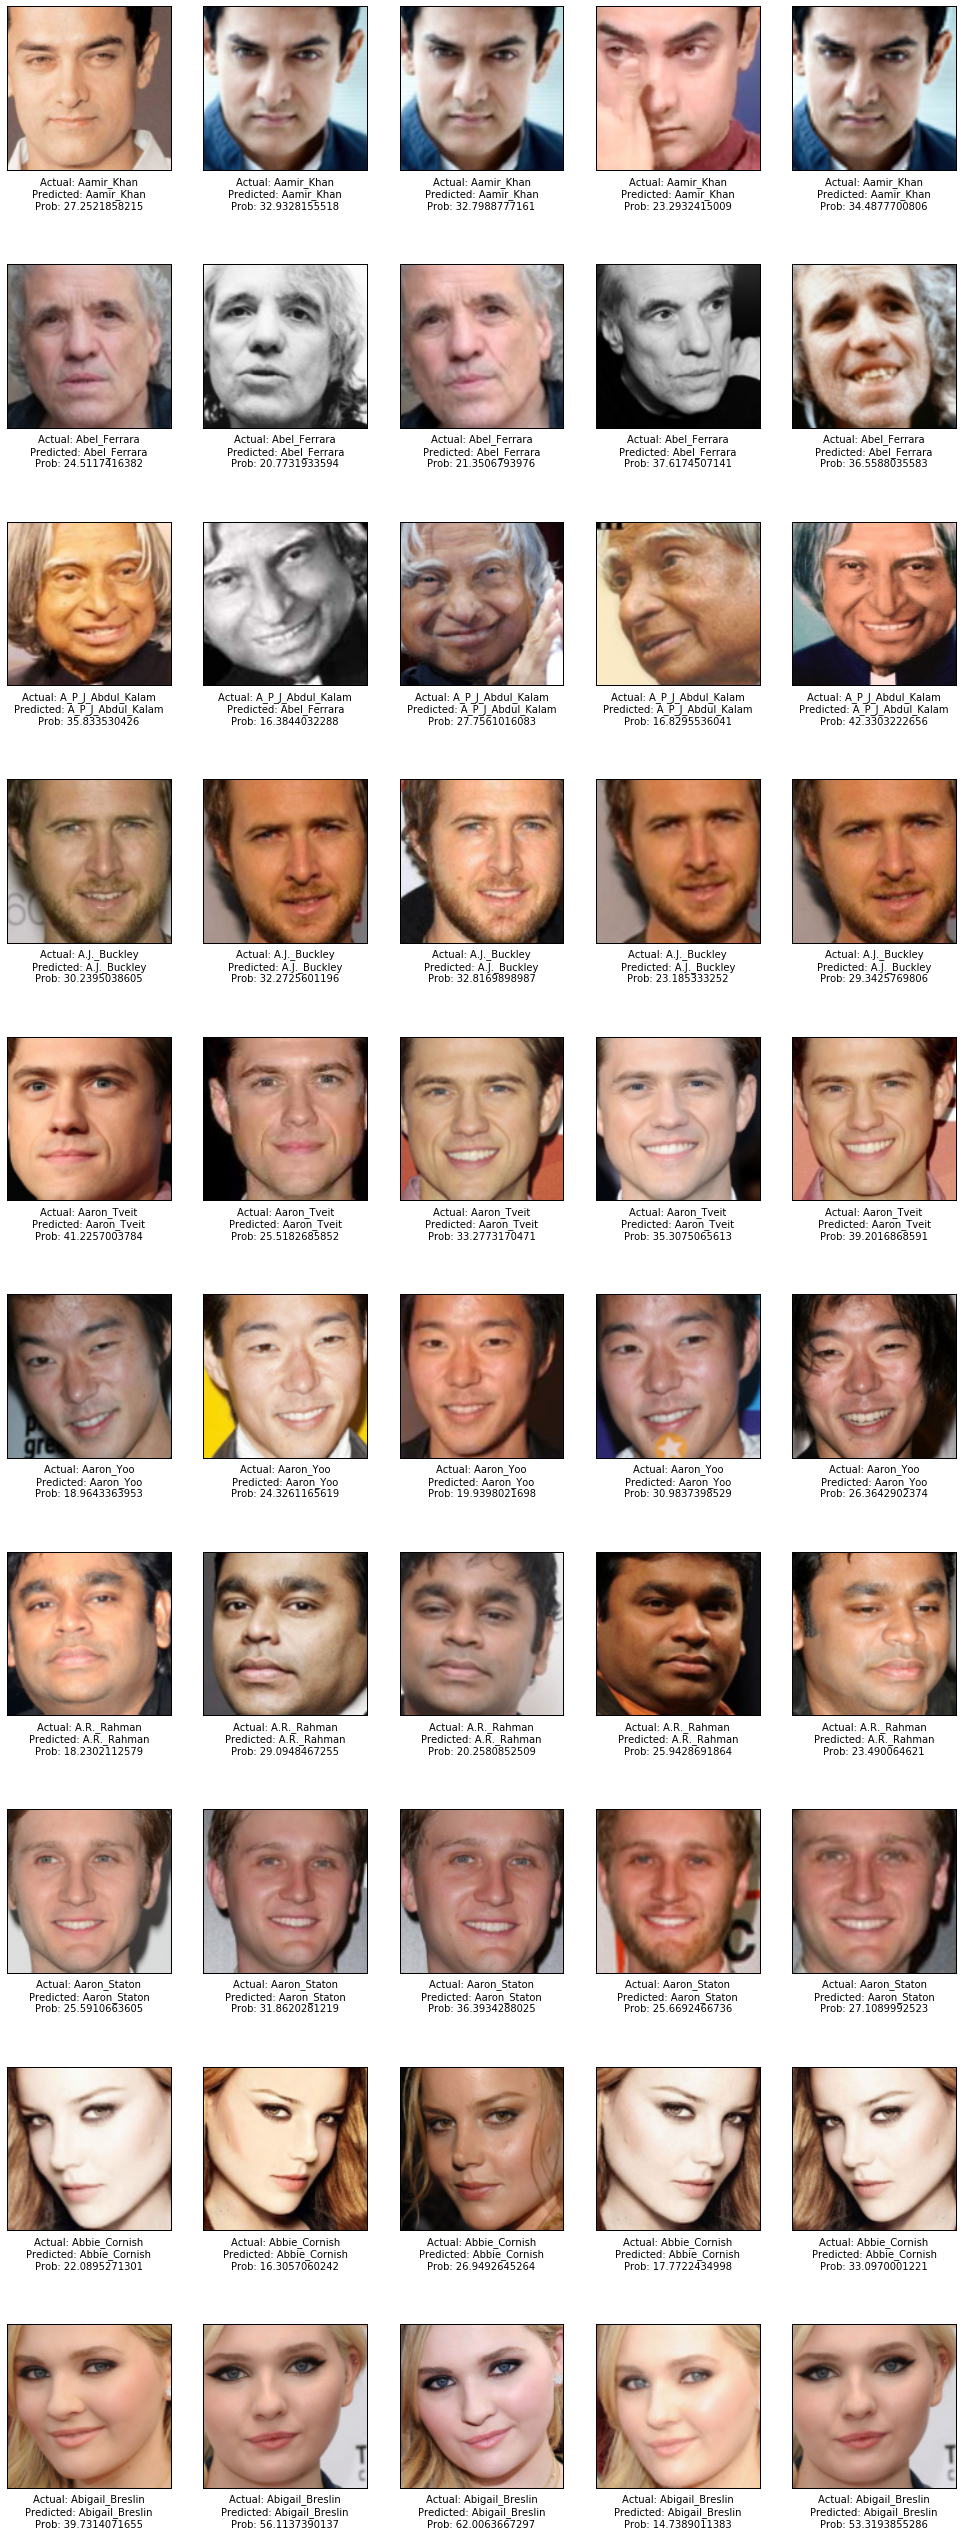

In [13]:
with graph.as_default():
#     print "\n".join([n.name for n in tf.get_default_graph().as_graph_def().node])
    session_conf = tf.ConfigProto(log_device_placement =False)
    sess = tf.Session(config = session_conf)
    with sess.as_default():
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess,checkpoint_file)
        features = graph.get_operation_by_name("input_features").outputs[0]
        labels = graph.get_operation_by_name("labels").outputs[0]
        keep_prob = graph.get_operation_by_name("keep_prob").outputs[0]
        prediction=graph.get_operation_by_name("ArgMax").outputs[0]
        probs=graph.get_operation_by_name("add_5").outputs[0]
        actual = tf.argmax(testset.labels,1)
        
        pred,act,prob = sess.run([prediction,actual, probs], feed_dict={features:testset.images, labels:testset.labels, keep_prob: 1.0})
        pred = np.array(map(lambda x:classes[x], pred))
        act = np.array(map(lambda x:new_classes[x], act))
        print float(sum(pred==act))/len(act)
#         print prob
        size = len(pred)
        plt.figure(figsize=(17,50))
        for i in xrange(1,size+1):
            plt.subplot(size/5+1, 5, i)
            plt.imshow(testset.images[i-1])
            plt.xlabel("Actual: {}\nPredicted: {}\nProb: {}".format(act[i-1],pred[i-1], max(prob[i-1])))
            plt.xticks([])
            plt.yticks([])
        